# Exploratory Data Analysis: Book Crossing Dataset

This notebook provides a comprehensive EDA of the Book Crossing dataset, focusing on:
1. Dataset overview and basic statistics
2. Interaction sparsity analysis
3. User and item activity distributions
4. Temporal dynamics
5. Data pathologies (popularity skew, cold-start)
6. Modeling implications and recommendations

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

from src.data.loader import load_all_data, load_ratings, load_books, load_users

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

/Users/n.protsiv/private/ucu-recs-system/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Data Loading and Overview

In [2]:
# Load all datasets
ratings, books, users = load_all_data('../data/raw')

print("Dataset Sizes:")
print(f"  Ratings: {len(ratings):,} interactions")
print(f"  Books: {len(books):,} items")
print(f"  Users: {len(users):,} users")

Dataset Sizes:
  Ratings: 1,149,780 interactions
  Books: 271,010 items
  Users: 278,859 users


In [3]:
# Examine ratings structure
print("Ratings DataFrame:")
print(ratings.head(10))
print(f"\nRatings dtypes:\n{ratings.dtypes}")

Ratings DataFrame:
  user_id        isbn  rating
0  276725  034545104X       0
1  276726  0155061224       5
2  276727  0446520802       0
3  276729  052165615X       3
4  276729  0521795028       6
5  276733  2080674722       0
6  276736  3257224281       8
7  276737  0600570967       6
8  276744  038550120X       7
9  276745   342310538      10

Ratings dtypes:
user_id    object
isbn       object
rating      int64
dtype: object


In [4]:
# Examine books structure
print("Books DataFrame:")
print(books.head())
print(f"\nBooks dtypes:\n{books.dtypes}")

Books DataFrame:
         isbn                                              title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 author    year                publisher  
0    Mark P. O. Morford  2002.0  Oxford University Press  
1  Richard Bruce Wright  2001.0    HarperFlamingo Canada  
2          Carlo D'Este  1991.0          HarperPerennial  
3      Gina Bari Kolata  1999.0     Farrar Straus Giroux  
4       E. J. W. Barber  1999.0   W. W. Norton & Company  

Books dtypes:
isbn          object
title         object
author        object
year         float64
publisher     object
dtype: object


In [5]:
# Examine users structure
print("Users DataFrame:")
print(users.head())
print(f"\nUsers dtypes:\n{users.dtypes}")

Users DataFrame:
  user_id   age location
0       1   NaN     None
1       2  18.0     None
2       3   NaN     None
3       4  17.0     None
4       5   NaN     None

Users dtypes:
user_id      object
age         float64
location     object
dtype: object


### 1.1 Rating Value Distribution

The Book Crossing dataset has a unique rating scheme:
- **0**: Implicit feedback (user interacted with the book but didn't rate)
- **1-10**: Explicit ratings

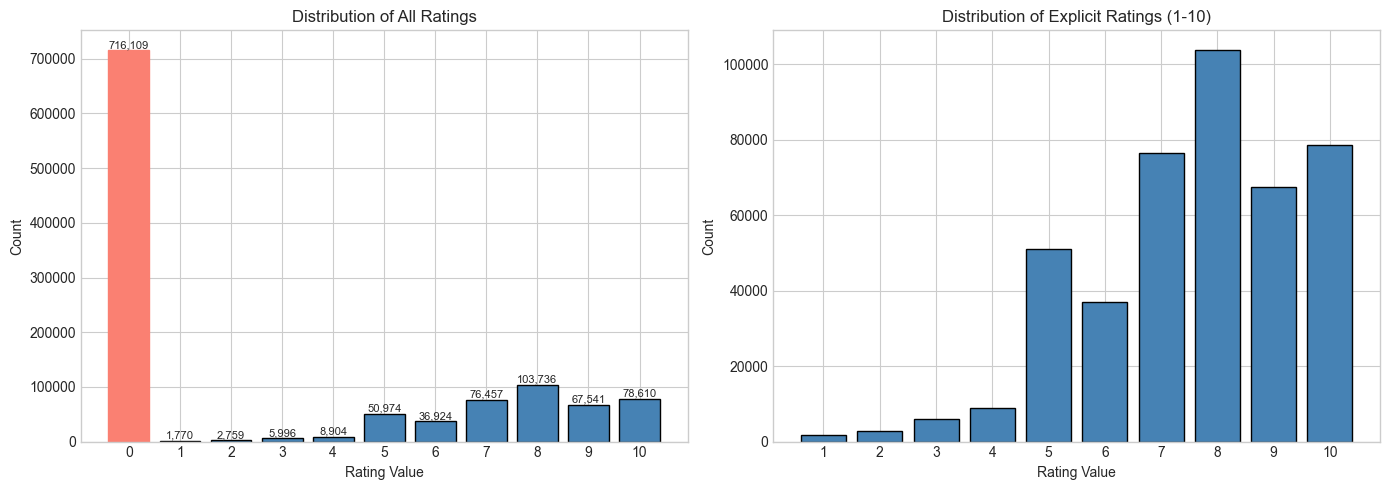


Implicit ratings (0): 716,109 (62.3%)
Explicit ratings (1-10): 433,671 (37.7%)

Explicit ratings statistics:
count    433671.000000
mean          7.601066
std           1.843798
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64


In [6]:
# Rating value distribution
rating_counts = ratings['rating'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All ratings
ax1 = axes[0]
bars = ax1.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
bars[0].set_color('salmon')  # Highlight implicit ratings
ax1.set_xlabel('Rating Value')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of All Ratings')
ax1.set_xticks(range(11))

# Add count labels
for bar, count in zip(bars, rating_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{count:,}', ha='center', va='bottom', fontsize=8)

# Explicit ratings only (1-10)
explicit_ratings = ratings[ratings['rating'] > 0]['rating']
ax2 = axes[1]
explicit_counts = explicit_ratings.value_counts().sort_index()
ax2.bar(explicit_counts.index, explicit_counts.values, color='steelblue', edgecolor='black')
ax2.set_xlabel('Rating Value')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Explicit Ratings (1-10)')
ax2.set_xticks(range(1, 11))

plt.tight_layout()
plt.savefig('../experiments/eda_rating_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistics
implicit_count = (ratings['rating'] == 0).sum()
explicit_count = (ratings['rating'] > 0).sum()
print(f"\nImplicit ratings (0): {implicit_count:,} ({100*implicit_count/len(ratings):.1f}%)")
print(f"Explicit ratings (1-10): {explicit_count:,} ({100*explicit_count/len(ratings):.1f}%)")
print(f"\nExplicit ratings statistics:")
print(explicit_ratings.describe())

## 2. Interaction Sparsity Analysis

Sparsity is a critical metric for recommender systems. High sparsity challenges collaborative filtering methods and informs the choice of algorithms.

In [7]:
# Calculate sparsity metrics
n_users = ratings['user_id'].nunique()
n_items = ratings['isbn'].nunique()
n_interactions = len(ratings)

# Total possible interactions
total_possible = n_users * n_items

# Sparsity
density = n_interactions / total_possible
sparsity = 1 - density

print("=" * 60)
print("INTERACTION SPARSITY ANALYSIS")
print("=" * 60)
print(f"\nUnique users in ratings: {n_users:,}")
print(f"Unique items in ratings: {n_items:,}")
print(f"Total interactions: {n_interactions:,}")
print(f"\nTotal possible interactions: {total_possible:,}")
print(f"Density: {density:.6f} ({density*100:.4f}%)")
print(f"Sparsity: {sparsity:.6f} ({sparsity*100:.4f}%)")
print(f"\nAverage interactions per user: {n_interactions/n_users:.2f}")
print(f"Average interactions per item: {n_interactions/n_items:.2f}")

INTERACTION SPARSITY ANALYSIS

Unique users in ratings: 105,283
Unique items in ratings: 340,553
Total interactions: 1,149,780

Total possible interactions: 35,854,441,499
Density: 0.000032 (0.0032%)
Sparsity: 0.999968 (99.9968%)

Average interactions per user: 10.92
Average interactions per item: 3.38


In [8]:
# Sparsity for explicit ratings only
explicit_df = ratings[ratings['rating'] > 0]
n_users_explicit = explicit_df['user_id'].nunique()
n_items_explicit = explicit_df['isbn'].nunique()
n_explicit = len(explicit_df)

total_possible_explicit = n_users_explicit * n_items_explicit
density_explicit = n_explicit / total_possible_explicit
sparsity_explicit = 1 - density_explicit

print("\n" + "=" * 60)
print("EXPLICIT RATINGS ONLY")
print("=" * 60)
print(f"\nUnique users: {n_users_explicit:,}")
print(f"Unique items: {n_items_explicit:,}")
print(f"Total explicit ratings: {n_explicit:,}")
print(f"\nDensity: {density_explicit:.6f} ({density_explicit*100:.4f}%)")
print(f"Sparsity: {sparsity_explicit:.6f} ({sparsity_explicit*100:.4f}%)")


EXPLICIT RATINGS ONLY

Unique users: 77,805
Unique items: 185,972
Total explicit ratings: 433,671

Density: 0.000030 (0.0030%)
Sparsity: 0.999970 (99.9970%)


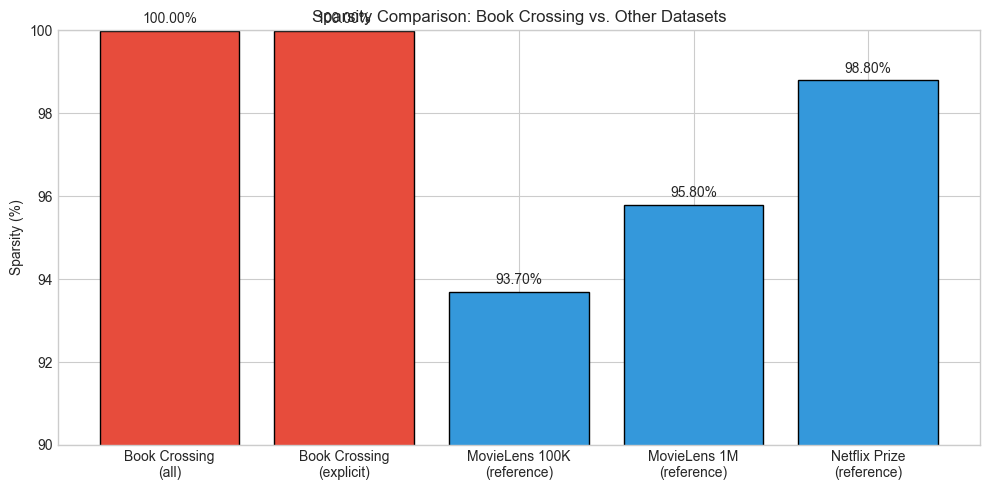

In [9]:
# Visualize sparsity comparison with other datasets
datasets_sparsity = {
    'Book Crossing\n(all)': sparsity * 100,
    'Book Crossing\n(explicit)': sparsity_explicit * 100,
    'MovieLens 100K\n(reference)': 93.7,
    'MovieLens 1M\n(reference)': 95.8,
    'Netflix Prize\n(reference)': 98.8
}

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(datasets_sparsity.keys(), datasets_sparsity.values(), 
              color=['#e74c3c', '#e74c3c', '#3498db', '#3498db', '#3498db'],
              edgecolor='black')
ax.set_ylabel('Sparsity (%)')
ax.set_title('Sparsity Comparison: Book Crossing vs. Other Datasets')
ax.set_ylim(90, 100)

for bar, val in zip(bars, datasets_sparsity.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../experiments/eda_sparsity_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. User and Item Activity Distributions

In [10]:
# Calculate user and item activity
user_activity = ratings.groupby('user_id').size()
item_activity = ratings.groupby('isbn').size()

print("USER ACTIVITY STATISTICS")
print(user_activity.describe())
print(f"\nUsers with 1 rating: {(user_activity == 1).sum():,} ({100*(user_activity == 1).sum()/len(user_activity):.1f}%)")
print(f"Users with ≤5 ratings: {(user_activity <= 5).sum():,} ({100*(user_activity <= 5).sum()/len(user_activity):.1f}%)")
print(f"Users with ≤10 ratings: {(user_activity <= 10).sum():,} ({100*(user_activity <= 10).sum()/len(user_activity):.1f}%)")

USER ACTIVITY STATISTICS
count    105283.000000
mean         10.920851
std          90.562825
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max       13602.000000
dtype: float64

Users with 1 rating: 59,166 (56.2%)
Users with ≤5 ratings: 85,566 (81.3%)
Users with ≤10 ratings: 93,230 (88.6%)


In [11]:
print("\nITEM ACTIVITY STATISTICS")
print(item_activity.describe())
print(f"\nItems with 1 rating: {(item_activity == 1).sum():,} ({100*(item_activity == 1).sum()/len(item_activity):.1f}%)")
print(f"Items with ≤5 ratings: {(item_activity <= 5).sum():,} ({100*(item_activity <= 5).sum()/len(item_activity):.1f}%)")
print(f"Items with ≤10 ratings: {(item_activity <= 10).sum():,} ({100*(item_activity <= 10).sum()/len(item_activity):.1f}%)")


ITEM ACTIVITY STATISTICS
count    340553.000000
mean          3.376215
std          12.436308
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2502.000000
dtype: float64

Items with 1 rating: 197,044 (57.9%)
Items with ≤5 ratings: 305,796 (89.8%)
Items with ≤10 ratings: 324,391 (95.3%)


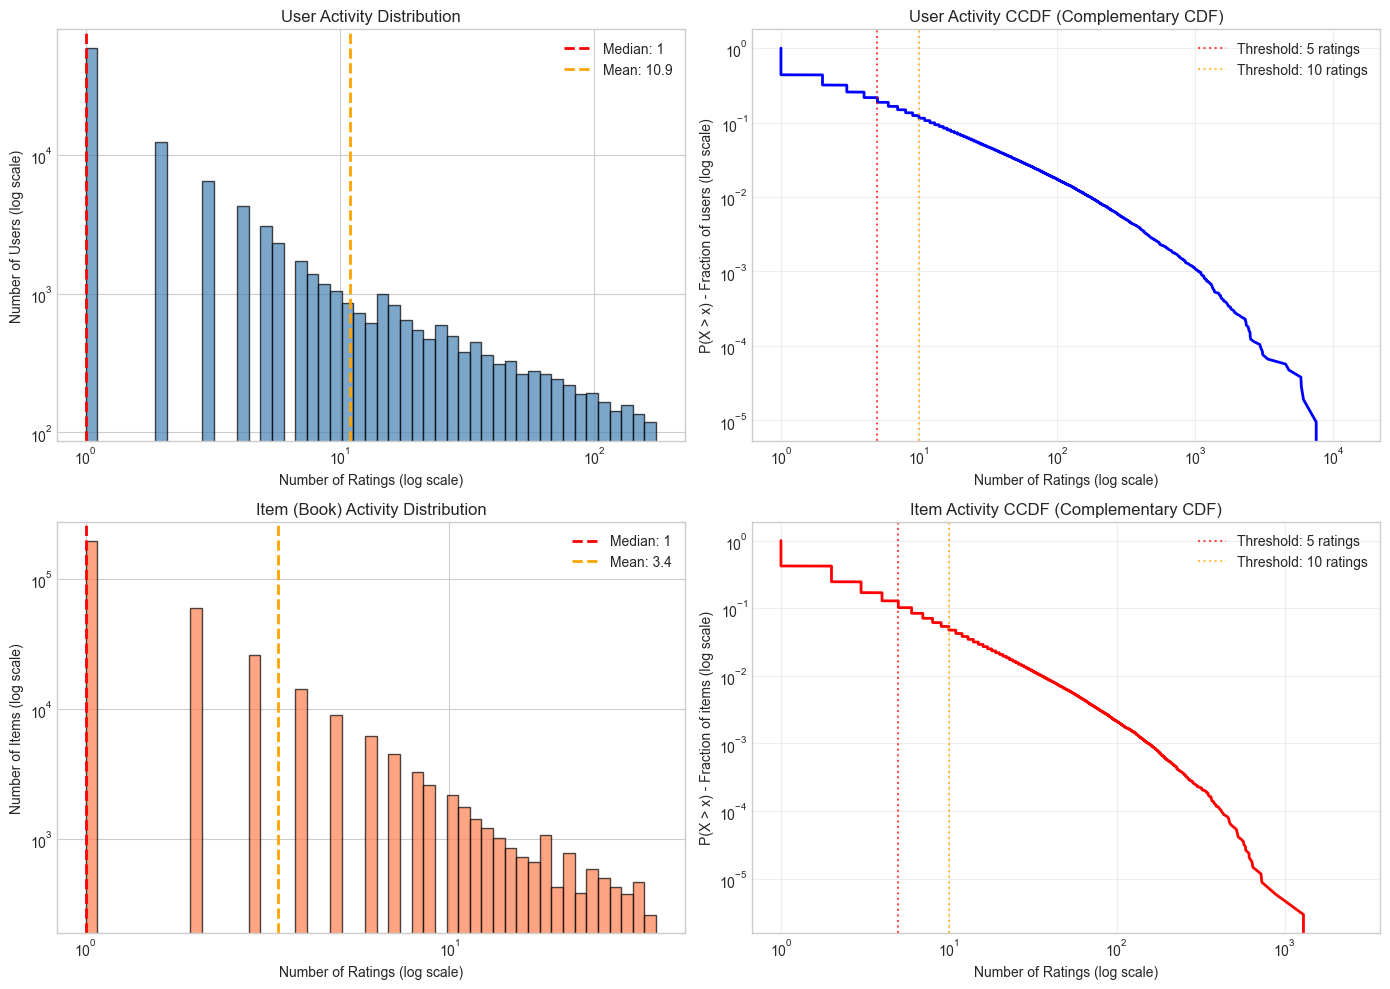


INTERPRETATION:
--------------------------------------------------
User activity: Median=1, Mean=10.9
  → Most users rate only 1 book(s), but some rate hundreds
  → The mean (10.9) >> median (1) confirms heavy right skew

Item activity: Median=1, Mean=3.4
  → Most books have only 1 rating(s)
  → A few popular books dominate with thousands of ratings


In [12]:
# Distribution plots - using log scale to handle extreme skew
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# User activity histogram with log y-scale
ax1 = axes[0, 0]
# Use logarithmic bins for better visualization of long-tail
max_val = int(user_activity.quantile(0.99))
bins = np.logspace(0, np.log10(max_val + 1), 50)
ax1.hist(user_activity[user_activity <= max_val], bins=bins, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Number of Ratings (log scale)')
ax1.set_ylabel('Number of Users (log scale)')
ax1.set_title('User Activity Distribution')
ax1.axvline(user_activity.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {user_activity.median():.0f}')
ax1.axvline(user_activity.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {user_activity.mean():.1f}')
ax1.legend()

# User activity - cumulative distribution
ax2 = axes[0, 1]
sorted_activity = np.sort(user_activity)
cumulative = np.arange(1, len(sorted_activity) + 1) / len(sorted_activity)
ax2.plot(sorted_activity, 1 - cumulative, 'b-', linewidth=2)  # CCDF
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Number of Ratings (log scale)')
ax2.set_ylabel('P(X > x) - Fraction of users (log scale)')
ax2.set_title('User Activity CCDF (Complementary CDF)')
ax2.axvline(5, color='red', linestyle=':', alpha=0.7, label='Threshold: 5 ratings')
ax2.axvline(10, color='orange', linestyle=':', alpha=0.7, label='Threshold: 10 ratings')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Item activity histogram with log y-scale
ax3 = axes[1, 0]
max_val_item = int(item_activity.quantile(0.99))
bins_item = np.logspace(0, np.log10(max_val_item + 1), 50)
ax3.hist(item_activity[item_activity <= max_val_item], bins=bins_item, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Number of Ratings (log scale)')
ax3.set_ylabel('Number of Items (log scale)')
ax3.set_title('Item (Book) Activity Distribution')
ax3.axvline(item_activity.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {item_activity.median():.0f}')
ax3.axvline(item_activity.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {item_activity.mean():.1f}')
ax3.legend()

# Item activity - cumulative distribution
ax4 = axes[1, 1]
sorted_item_activity = np.sort(item_activity)
cumulative_item = np.arange(1, len(sorted_item_activity) + 1) / len(sorted_item_activity)
ax4.plot(sorted_item_activity, 1 - cumulative_item, 'r-', linewidth=2)  # CCDF
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Number of Ratings (log scale)')
ax4.set_ylabel('P(X > x) - Fraction of items (log scale)')
ax4.set_title('Item Activity CCDF (Complementary CDF)')
ax4.axvline(5, color='red', linestyle=':', alpha=0.7, label='Threshold: 5 ratings')
ax4.axvline(10, color='orange', linestyle=':', alpha=0.7, label='Threshold: 10 ratings')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/eda_activity_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

# Print interpretation
print("\nINTERPRETATION:")
print("-" * 50)
print(f"User activity: Median={user_activity.median():.0f}, Mean={user_activity.mean():.1f}")
print(f"  → Most users rate only {user_activity.median():.0f} book(s), but some rate hundreds")
print(f"  → The mean ({user_activity.mean():.1f}) >> median ({user_activity.median():.0f}) confirms heavy right skew")
print(f"\nItem activity: Median={item_activity.median():.0f}, Mean={item_activity.mean():.1f}")
print(f"  → Most books have only {item_activity.median():.0f} rating(s)")
print(f"  → A few popular books dominate with thousands of ratings")

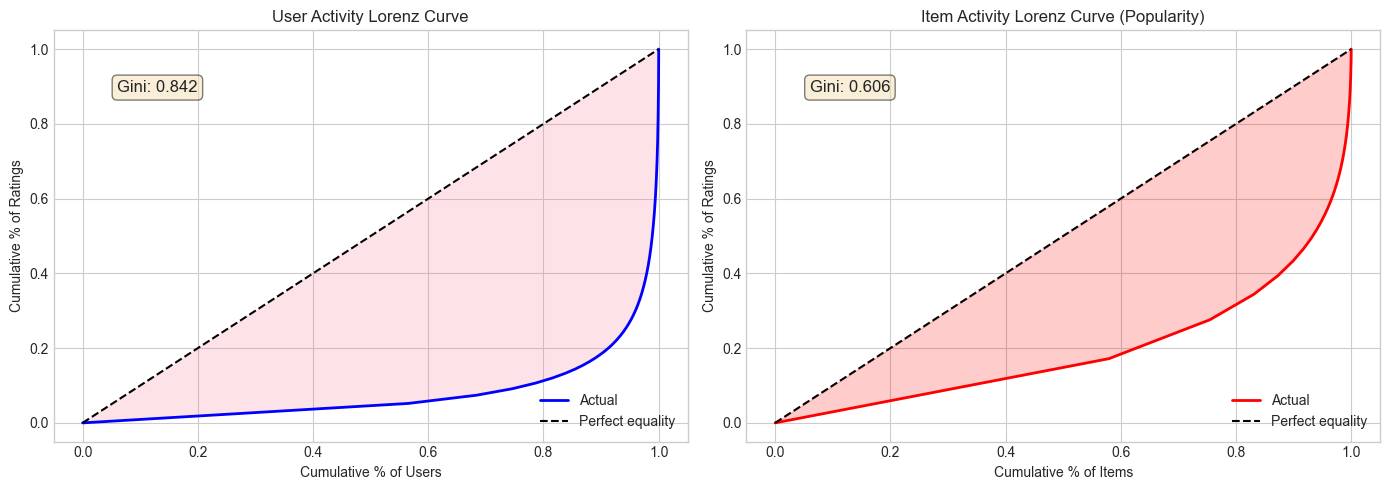

Gini coefficient for user activity: 0.842
Gini coefficient for item popularity: 0.606

(Gini = 0: perfect equality, Gini = 1: maximum inequality)


In [13]:
# Cumulative distribution - Lorenz curve for activity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User Lorenz curve
ax1 = axes[0]
user_sorted = np.sort(user_activity.values)
user_cum = np.cumsum(user_sorted) / user_sorted.sum()
user_pct = np.arange(1, len(user_sorted) + 1) / len(user_sorted)
ax1.plot(user_pct, user_cum, 'b-', linewidth=2, label='Actual')
ax1.plot([0, 1], [0, 1], 'k--', label='Perfect equality')
ax1.fill_between(user_pct, user_cum, user_pct, alpha=0.2)
ax1.set_xlabel('Cumulative % of Users')
ax1.set_ylabel('Cumulative % of Ratings')
ax1.set_title('User Activity Lorenz Curve')
ax1.legend()

# Calculate Gini coefficient for users
n = len(user_sorted)
gini_user = (2 * np.sum(np.arange(1, n+1) * user_sorted) - (n + 1) * np.sum(user_sorted)) / (n * np.sum(user_sorted))
ax1.text(0.1, 0.85, f'Gini: {gini_user:.3f}', transform=ax1.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Item Lorenz curve
ax2 = axes[1]
item_sorted = np.sort(item_activity.values)
item_cum = np.cumsum(item_sorted) / item_sorted.sum()
item_pct = np.arange(1, len(item_sorted) + 1) / len(item_sorted)
ax2.plot(item_pct, item_cum, 'r-', linewidth=2, label='Actual')
ax2.plot([0, 1], [0, 1], 'k--', label='Perfect equality')
ax2.fill_between(item_pct, item_cum, item_pct, alpha=0.2, color='red')
ax2.set_xlabel('Cumulative % of Items')
ax2.set_ylabel('Cumulative % of Ratings')
ax2.set_title('Item Activity Lorenz Curve (Popularity)')
ax2.legend()

# Calculate Gini coefficient for items
n = len(item_sorted)
gini_item = (2 * np.sum(np.arange(1, n+1) * item_sorted) - (n + 1) * np.sum(item_sorted)) / (n * np.sum(item_sorted))
ax2.text(0.1, 0.85, f'Gini: {gini_item:.3f}', transform=ax2.transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../experiments/eda_lorenz_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Gini coefficient for user activity: {gini_user:.3f}")
print(f"Gini coefficient for item popularity: {gini_item:.3f}")
print("\n(Gini = 0: perfect equality, Gini = 1: maximum inequality)")

## 4. Temporal Dynamics

The Book Crossing dataset was collected in 2004, and while it doesn't have explicit timestamps, we can analyze temporal patterns through publication years.

In [14]:
# Analyze publication years
# First, merge ratings with books to get publication years
ratings_with_year = ratings.merge(books[['isbn', 'year', 'title', 'author']], on='isbn', how='left')

# Clean publication years (filter out clearly invalid values)
valid_years = ratings_with_year[
    (ratings_with_year['year'] >= 1800) & 
    (ratings_with_year['year'] <= 2004)  # Dataset was collected in 2004
]['year']

print(f"Ratings with valid publication years: {len(valid_years):,} ({100*len(valid_years)/len(ratings):.1f}%)")
print(f"\nPublication year statistics:")
print(valid_years.describe())

Ratings with valid publication years: 1,016,411 (88.4%)

Publication year statistics:
count    1.016411e+06
mean     1.995301e+03
std      7.306461e+00
min      1.806000e+03
25%      1.992000e+03
50%      1.997000e+03
75%      2.001000e+03
max      2.004000e+03
Name: year, dtype: float64


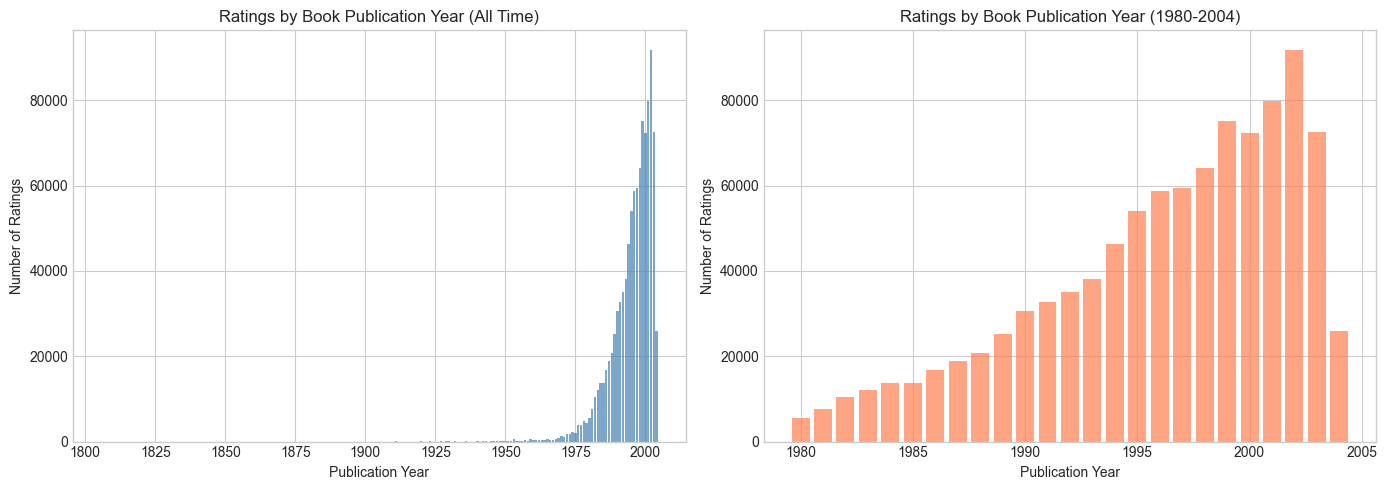

In [15]:
# Publication year distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full history
ax1 = axes[0]
year_counts = valid_years.value_counts().sort_index()
ax1.bar(year_counts.index, year_counts.values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Publication Year')
ax1.set_ylabel('Number of Ratings')
ax1.set_title('Ratings by Book Publication Year (All Time)')

# Recent years (1980-2004)
ax2 = axes[1]
recent_years = valid_years[valid_years >= 1980]
recent_counts = recent_years.value_counts().sort_index()
ax2.bar(recent_counts.index, recent_counts.values, color='coral', alpha=0.7)
ax2.set_xlabel('Publication Year')
ax2.set_ylabel('Number of Ratings')
ax2.set_title('Ratings by Book Publication Year (1980-2004)')

plt.tight_layout()
plt.savefig('../experiments/eda_temporal_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Analyze recency bias
# What percentage of ratings are for books published in the last 5 years (1999-2004)?
recent_5y = valid_years[valid_years >= 1999].count()
recent_10y = valid_years[valid_years >= 1994].count()

print("RECENCY BIAS ANALYSIS")
print(f"\nRatings for books published 1999-2004: {recent_5y:,} ({100*recent_5y/len(valid_years):.1f}%)")
print(f"Ratings for books published 1994-2004: {recent_10y:,} ({100*recent_10y/len(valid_years):.1f}%)")
print(f"Ratings for books published before 1994: {len(valid_years) - recent_10y:,} ({100*(len(valid_years) - recent_10y)/len(valid_years):.1f}%)")

RECENCY BIAS ANALYSIS

Ratings for books published 1999-2004: 417,479 (41.1%)
Ratings for books published 1994-2004: 700,240 (68.9%)
Ratings for books published before 1994: 316,171 (31.1%)


In [17]:
# Analyze rating patterns by publication decade
ratings_with_year['decade'] = (ratings_with_year['year'] // 10 * 10).astype('Int64')

decade_stats = ratings_with_year[
    (ratings_with_year['decade'] >= 1950) & 
    (ratings_with_year['decade'] <= 2000) &
    (ratings_with_year['rating'] > 0)  # Only explicit ratings
].groupby('decade').agg({
    'rating': ['count', 'mean', 'std'],
    'isbn': 'nunique',
    'user_id': 'nunique'
}).round(2)

decade_stats.columns = ['n_ratings', 'avg_rating', 'std_rating', 'n_books', 'n_users']
print("Rating statistics by decade (explicit ratings only):")
print(decade_stats)

Rating statistics by decade (explicit ratings only):
        n_ratings  avg_rating  std_rating  n_books  n_users
decade                                                     
1950         1003        8.15        1.78      365      723
1960         1774        7.90        1.91      931     1186
1970         9509        7.78        1.88     5640     4656
1980        47270        7.66        1.87    23821    15124
1990       180110        7.58        1.84    69691    41892
2000       137904        7.66        1.83    46346    37462


## 5. Data Pathologies

### 5.1 Popularity Skew (Long-Tail Distribution)

In [18]:
# Popularity analysis
item_popularity = item_activity.sort_values(ascending=False).reset_index(drop=True)

# Calculate concentration metrics
top_1_pct = int(len(item_popularity) * 0.01)
top_5_pct = int(len(item_popularity) * 0.05)
top_10_pct = int(len(item_popularity) * 0.10)
top_20_pct = int(len(item_popularity) * 0.20)

total_ratings = item_popularity.sum()

print("=" * 60)
print("POPULARITY SKEW ANALYSIS")
print("=" * 60)
print(f"\nTop 1% of items ({top_1_pct:,} books) account for {100*item_popularity[:top_1_pct].sum()/total_ratings:.1f}% of ratings")
print(f"Top 5% of items ({top_5_pct:,} books) account for {100*item_popularity[:top_5_pct].sum()/total_ratings:.1f}% of ratings")
print(f"Top 10% of items ({top_10_pct:,} books) account for {100*item_popularity[:top_10_pct].sum()/total_ratings:.1f}% of ratings")
print(f"Top 20% of items ({top_20_pct:,} books) account for {100*item_popularity[:top_20_pct].sum()/total_ratings:.1f}% of ratings")

# Bottom half
bottom_half = len(item_popularity) // 2
print(f"\nBottom 50% of items ({bottom_half:,} books) account for {100*item_popularity[-bottom_half:].sum()/total_ratings:.1f}% of ratings")

POPULARITY SKEW ANALYSIS

Top 1% of items (3,405 books) account for 25.1% of ratings
Top 5% of items (17,027 books) account for 45.5% of ratings
Top 10% of items (34,055 books) account for 56.5% of ratings
Top 20% of items (68,110 books) account for 68.4% of ratings

Bottom 50% of items (170,276 books) account for 14.8% of ratings


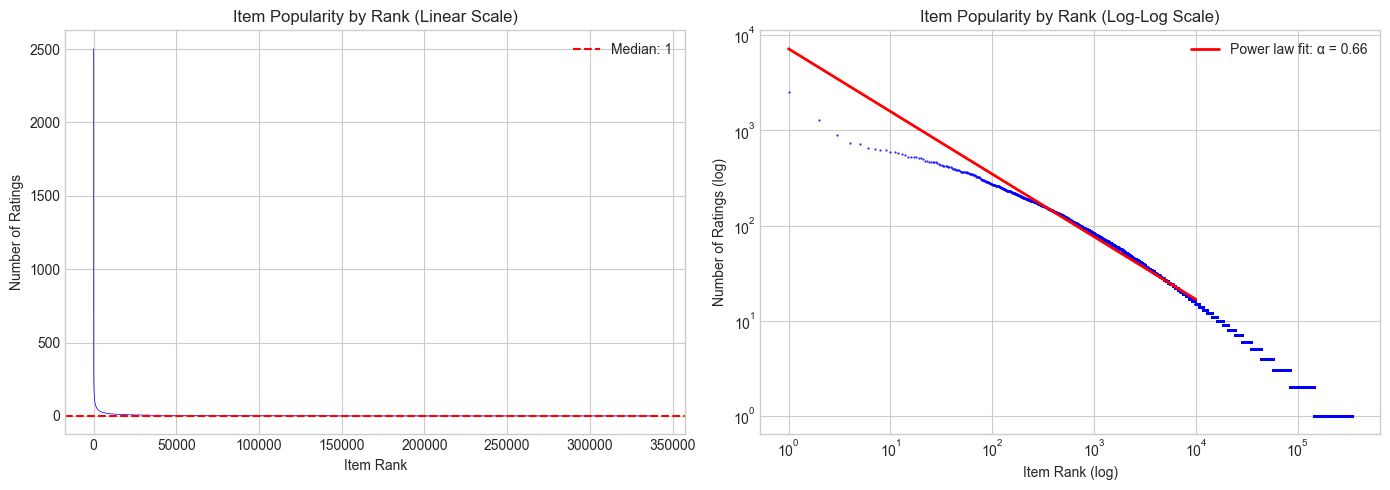


Power law exponent (Zipf's α): 0.66
(α ≈ 1 indicates classic Zipf's law; α > 1 indicates stronger concentration)


In [19]:
# Visualize popularity distribution (Rank vs Rating count)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1 = axes[0]
ax1.plot(range(1, len(item_popularity) + 1), item_popularity.values, 'b-', linewidth=0.5)
ax1.set_xlabel('Item Rank')
ax1.set_ylabel('Number of Ratings')
ax1.set_title('Item Popularity by Rank (Linear Scale)')
ax1.axhline(item_popularity.median(), color='red', linestyle='--', 
            label=f'Median: {item_popularity.median():.0f}')
ax1.legend()

# Log-log scale (Zipf's law check)
ax2 = axes[1]
ax2.loglog(range(1, len(item_popularity) + 1), item_popularity.values, 'b.', markersize=1)
ax2.set_xlabel('Item Rank (log)')
ax2.set_ylabel('Number of Ratings (log)')
ax2.set_title('Item Popularity by Rank (Log-Log Scale)')

# Fit power law to top items
top_n = 10000
ranks = np.arange(1, top_n + 1)
ratings_top = item_popularity.values[:top_n]
log_ranks = np.log(ranks)
log_ratings = np.log(ratings_top)
slope, intercept = np.polyfit(log_ranks, log_ratings, 1)
ax2.plot(ranks, np.exp(intercept) * ranks ** slope, 'r-', linewidth=2, 
         label=f'Power law fit: α = {-slope:.2f}')
ax2.legend()

plt.tight_layout()
plt.savefig('../experiments/eda_popularity_skew.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPower law exponent (Zipf's α): {-slope:.2f}")
print("(α ≈ 1 indicates classic Zipf's law; α > 1 indicates stronger concentration)")

In [20]:
# Most popular items
top_books = ratings.groupby('isbn').agg({
    'user_id': 'count',
    'rating': 'mean'
}).rename(columns={'user_id': 'n_ratings', 'rating': 'avg_rating'})
top_books = top_books.merge(books[['isbn', 'title', 'author']], on='isbn', how='left')
top_books = top_books.sort_values('n_ratings', ascending=False)

print("Top 20 Most Rated Books:")
print(top_books.head(20)[['title', 'author', 'n_ratings', 'avg_rating']].to_string())

Top 20 Most Rated Books:
                                                                   title           author  n_ratings  avg_rating
247409                                                       Wild Animus     Rich Shapero       2502    1.019584
47371                                          The Lovely Bones: A Novel     Alice Sebold       1295    4.468726
83359                                                  The Da Vinci Code        Dan Brown        883    4.652322
9637                     Divine Secrets of the Ya-Ya Sisterhood: A Novel    Rebecca Wells        732    3.448087
41007                                The Red Tent (Bestselling Backlist)    Anita Diamant        723    4.334716
101670                                                   A Painted House     John Grisham        647    3.187017
166706                                                               NaN              NaN        639    4.381847
28153                                            The Secret Life of Bee

### 5.2 Cold-Start Problem Analysis

In [21]:
# Cold-start analysis
print("=" * 60)
print("COLD-START PROBLEM ANALYSIS")
print("=" * 60)

# User cold-start
user_thresholds = [1, 2, 3, 5, 10, 20]
print("\nUSER COLD-START:")
for thresh in user_thresholds:
    cold_users = (user_activity <= thresh).sum()
    print(f"  Users with ≤{thresh:2d} ratings: {cold_users:,} ({100*cold_users/len(user_activity):.1f}%)")

# Item cold-start
print("\nITEM COLD-START:")
for thresh in user_thresholds:
    cold_items = (item_activity <= thresh).sum()
    print(f"  Items with ≤{thresh:2d} ratings: {cold_items:,} ({100*cold_items/len(item_activity):.1f}%)")

COLD-START PROBLEM ANALYSIS

USER COLD-START:
  Users with ≤ 1 ratings: 59,166 (56.2%)
  Users with ≤ 2 ratings: 71,668 (68.1%)
  Users with ≤ 3 ratings: 78,202 (74.3%)
  Users with ≤ 5 ratings: 85,566 (81.3%)
  Users with ≤10 ratings: 93,230 (88.6%)
  Users with ≤20 ratings: 98,205 (93.3%)

ITEM COLD-START:
  Items with ≤ 1 ratings: 197,044 (57.9%)
  Items with ≤ 2 ratings: 256,705 (75.4%)
  Items with ≤ 3 ratings: 282,681 (83.0%)
  Items with ≤ 5 ratings: 305,796 (89.8%)
  Items with ≤10 ratings: 324,391 (95.3%)
  Items with ≤20 ratings: 333,489 (97.9%)


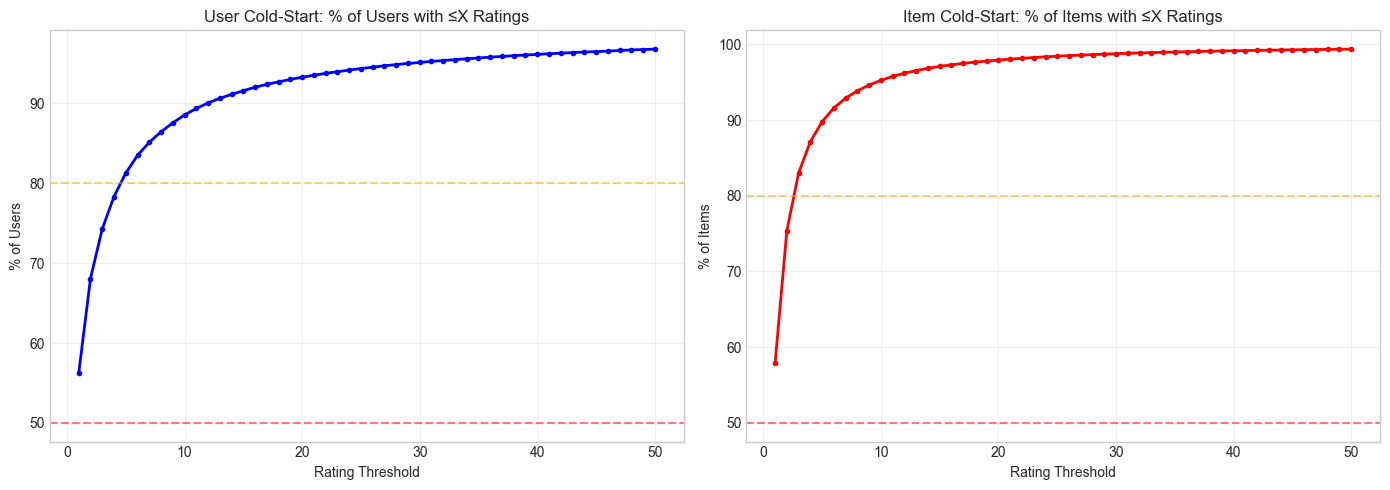

In [22]:
# Visualize cold-start severity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User cold-start cumulative
ax1 = axes[0]
thresholds = range(1, 51)
user_cold_pct = [(user_activity <= t).sum() / len(user_activity) * 100 for t in thresholds]
ax1.plot(thresholds, user_cold_pct, 'b-', linewidth=2, marker='o', markersize=3)
ax1.axhline(50, color='red', linestyle='--', alpha=0.5)
ax1.axhline(80, color='orange', linestyle='--', alpha=0.5)
ax1.set_xlabel('Rating Threshold')
ax1.set_ylabel('% of Users')
ax1.set_title('User Cold-Start: % of Users with ≤X Ratings')
ax1.grid(True, alpha=0.3)

# Item cold-start cumulative
ax2 = axes[1]
item_cold_pct = [(item_activity <= t).sum() / len(item_activity) * 100 for t in thresholds]
ax2.plot(thresholds, item_cold_pct, 'r-', linewidth=2, marker='o', markersize=3)
ax2.axhline(50, color='red', linestyle='--', alpha=0.5)
ax2.axhline(80, color='orange', linestyle='--', alpha=0.5)
ax2.set_xlabel('Rating Threshold')
ax2.set_ylabel('% of Items')
ax2.set_title('Item Cold-Start: % of Items with ≤X Ratings')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/eda_cold_start.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 Additional Pathology: Implicit vs Explicit Feedback Imbalance

In [23]:
# Analyze users who only have implicit ratings
user_explicit_count = ratings[ratings['rating'] > 0].groupby('user_id').size()
users_with_explicit = set(user_explicit_count.index)
all_users = set(ratings['user_id'].unique())
users_implicit_only = all_users - users_with_explicit

print("=" * 60)
print("IMPLICIT VS EXPLICIT FEEDBACK ANALYSIS")
print("=" * 60)
print(f"\nTotal unique users: {len(all_users):,}")
print(f"Users with at least one explicit rating: {len(users_with_explicit):,} ({100*len(users_with_explicit)/len(all_users):.1f}%)")
print(f"Users with ONLY implicit ratings: {len(users_implicit_only):,} ({100*len(users_implicit_only)/len(all_users):.1f}%)")

IMPLICIT VS EXPLICIT FEEDBACK ANALYSIS

Total unique users: 105,283
Users with at least one explicit rating: 77,805 (73.9%)
Users with ONLY implicit ratings: 27,478 (26.1%)


In [24]:
# Analyze items with only implicit ratings
item_explicit_count = ratings[ratings['rating'] > 0].groupby('isbn').size()
items_with_explicit = set(item_explicit_count.index)
all_items = set(ratings['isbn'].unique())
items_implicit_only = all_items - items_with_explicit

print(f"\nTotal unique items in ratings: {len(all_items):,}")
print(f"Items with at least one explicit rating: {len(items_with_explicit):,} ({100*len(items_with_explicit)/len(all_items):.1f}%)")
print(f"Items with ONLY implicit ratings: {len(items_implicit_only):,} ({100*len(items_implicit_only)/len(all_items):.1f}%)")


Total unique items in ratings: 340,553
Items with at least one explicit rating: 185,972 (54.6%)
Items with ONLY implicit ratings: 154,581 (45.4%)


### 5.4 Rating Bias Analysis

In [25]:
# Analyze rating bias per user (explicit ratings only)
explicit_ratings_df = ratings[ratings['rating'] > 0]

user_rating_stats = explicit_ratings_df.groupby('user_id')['rating'].agg(['mean', 'std', 'count'])
user_rating_stats = user_rating_stats[user_rating_stats['count'] >= 5]  # Users with at least 5 ratings

print("=" * 60)
print("USER RATING BIAS ANALYSIS (users with ≥5 explicit ratings)")
print("=" * 60)
print(f"\nNumber of users analyzed: {len(user_rating_stats):,}")
print(f"\nDistribution of user mean ratings:")
print(user_rating_stats['mean'].describe())

# How many users rate consistently high or low?
harsh_raters = (user_rating_stats['mean'] < 5).sum()
lenient_raters = (user_rating_stats['mean'] > 8).sum()
print(f"\n'Harsh' raters (mean < 5): {harsh_raters:,} ({100*harsh_raters/len(user_rating_stats):.1f}%)")
print(f"'Lenient' raters (mean > 8): {lenient_raters:,} ({100*lenient_raters/len(user_rating_stats):.1f}%)")

USER RATING BIAS ANALYSIS (users with ≥5 explicit ratings)

Number of users analyzed: 14,220

Distribution of user mean ratings:
count    14220.000000
mean         7.460649
std          1.077445
min          1.000000
25%          6.800000
50%          7.500000
75%          8.200000
max         10.000000
Name: mean, dtype: float64

'Harsh' raters (mean < 5): 164 (1.2%)
'Lenient' raters (mean > 8): 4,205 (29.6%)


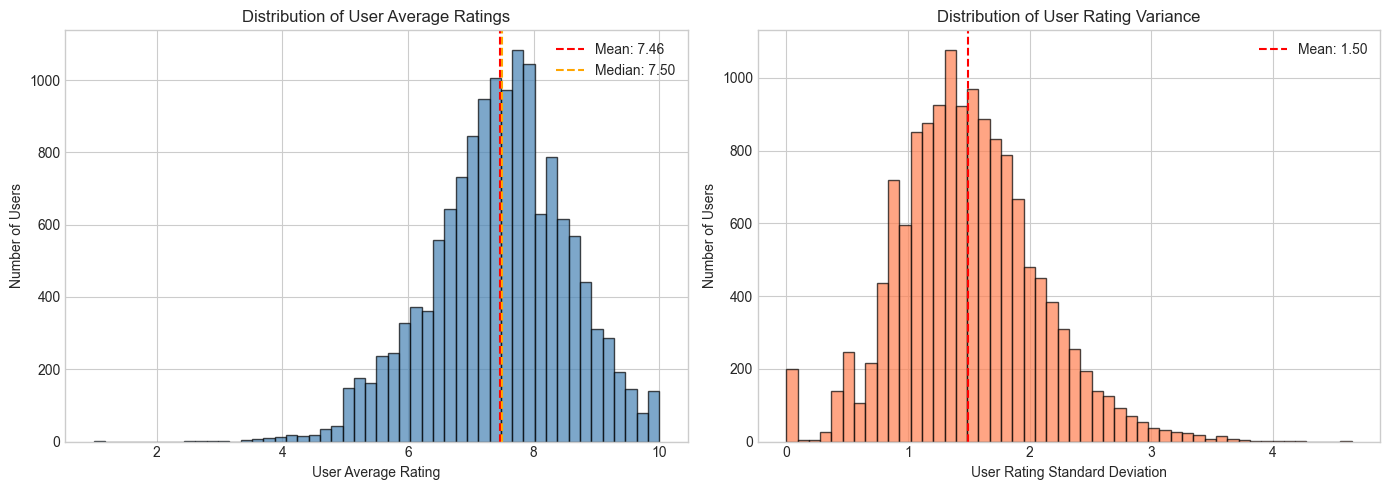

In [26]:
# Visualize user rating bias
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of user mean ratings
ax1 = axes[0]
ax1.hist(user_rating_stats['mean'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(user_rating_stats['mean'].mean(), color='red', linestyle='--', 
            label=f'Mean: {user_rating_stats["mean"].mean():.2f}')
ax1.axvline(user_rating_stats['mean'].median(), color='orange', linestyle='--', 
            label=f'Median: {user_rating_stats["mean"].median():.2f}')
ax1.set_xlabel('User Average Rating')
ax1.set_ylabel('Number of Users')
ax1.set_title('Distribution of User Average Ratings')
ax1.legend()

# Distribution of user rating std
ax2 = axes[1]
ax2.hist(user_rating_stats['std'].dropna(), bins=50, color='coral', edgecolor='black', alpha=0.7)
ax2.axvline(user_rating_stats['std'].mean(), color='red', linestyle='--', 
            label=f'Mean: {user_rating_stats["std"].mean():.2f}')
ax2.set_xlabel('User Rating Standard Deviation')
ax2.set_ylabel('Number of Users')
ax2.set_title('Distribution of User Rating Variance')
ax2.legend()

plt.tight_layout()
plt.savefig('../experiments/eda_rating_bias.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. User Demographics Analysis

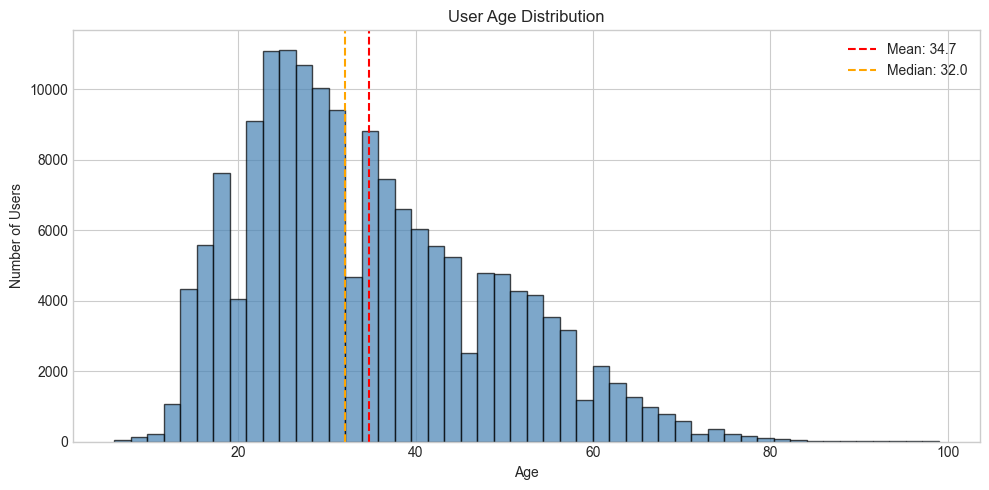

Users with valid age: 165,885 (59.5%)
Age statistics:
count    165885.000000
mean         34.723574
std          13.602057
min           6.000000
25%          24.000000
50%          32.000000
75%          44.000000
max          99.000000
Name: age, dtype: float64


In [27]:
# Age distribution
valid_ages = users[(users['age'] > 5) & (users['age'] < 100)]['age']

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(valid_ages, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(valid_ages.mean(), color='red', linestyle='--', label=f'Mean: {valid_ages.mean():.1f}')
ax.axvline(valid_ages.median(), color='orange', linestyle='--', label=f'Median: {valid_ages.median():.1f}')
ax.set_xlabel('Age')
ax.set_ylabel('Number of Users')
ax.set_title('User Age Distribution')
ax.legend()
plt.tight_layout()
plt.savefig('../experiments/eda_age_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Users with valid age: {len(valid_ages):,} ({100*len(valid_ages)/len(users):.1f}%)")
print(f"Age statistics:")
print(valid_ages.describe())

In [28]:
# Location analysis (if available)
if 'location' in users.columns and users['location'].notna().any():
    def extract_country(location):
        if pd.isna(location):
            return 'Unknown'
        parts = str(location).split(',')
        if len(parts) >= 1:
            return parts[-1].strip()
        return 'Unknown'

    users['country'] = users['location'].apply(extract_country)
    country_counts = users['country'].value_counts().head(20)

    fig, ax = plt.subplots(figsize=(12, 6))
    country_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
    ax.set_xlabel('Country')
    ax.set_ylabel('Number of Users')
    ax.set_title('Top 20 Countries by Number of Users')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('../experiments/eda_country_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Top 10 countries:")
    print(country_counts.head(10))
else:
    print("Location data not available in this version of the dataset.")
    print("This analysis is skipped.")

Location data not available in this version of the dataset.
This analysis is skipped.


## 7. Summary Statistics and Modeling Implications

In [29]:
# Create summary dataframe
summary_stats = {
    'Metric': [
        'Total Ratings',
        'Unique Users',
        'Unique Items (Books)',
        'Sparsity (all interactions)',
        'Sparsity (explicit only)',
        'Implicit Ratings (%)',
        'Explicit Ratings (%)',
        'Avg Ratings per User',
        'Avg Ratings per Item',
        'Median Ratings per User',
        'Median Ratings per Item',
        'Gini (User Activity)',
        'Gini (Item Popularity)',
        'Cold Users (≤5 ratings)',
        'Cold Items (≤5 ratings)',
    ],
    'Value': [
        f'{n_interactions:,}',
        f'{n_users:,}',
        f'{n_items:,}',
        f'{sparsity*100:.4f}%',
        f'{sparsity_explicit*100:.4f}%',
        f'{100*implicit_count/len(ratings):.1f}%',
        f'{100*explicit_count/len(ratings):.1f}%',
        f'{n_interactions/n_users:.2f}',
        f'{n_interactions/n_items:.2f}',
        f'{user_activity.median():.0f}',
        f'{item_activity.median():.0f}',
        f'{gini_user:.3f}',
        f'{gini_item:.3f}',
        f'{(user_activity <= 5).sum():,} ({100*(user_activity <= 5).sum()/len(user_activity):.1f}%)',
        f'{(item_activity <= 5).sum():,} ({100*(item_activity <= 5).sum()/len(item_activity):.1f}%)',
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("=" * 60)
print("BOOK CROSSING DATASET - SUMMARY STATISTICS")
print("=" * 60)
print(summary_df.to_string(index=False))

BOOK CROSSING DATASET - SUMMARY STATISTICS
                     Metric           Value
              Total Ratings       1,149,780
               Unique Users         105,283
       Unique Items (Books)         340,553
Sparsity (all interactions)        99.9968%
   Sparsity (explicit only)        99.9970%
       Implicit Ratings (%)           62.3%
       Explicit Ratings (%)           37.7%
       Avg Ratings per User           10.92
       Avg Ratings per Item            3.38
    Median Ratings per User               1
    Median Ratings per Item               1
       Gini (User Activity)           0.842
     Gini (Item Popularity)           0.606
    Cold Users (≤5 ratings)  85,566 (81.3%)
    Cold Items (≤5 ratings) 305,796 (89.8%)


In [30]:
# Save summary to CSV
summary_df.to_csv('../experiments/eda_summary_stats.csv', index=False)
print("\nSummary statistics saved to experiments/eda_summary_stats.csv")


Summary statistics saved to experiments/eda_summary_stats.csv


## 8. Modeling Implications & Recommendations

Based on this EDA, here are the key implications for building recommender systems:

### 8.1 Data Preprocessing Recommendations

1. **Separate implicit and explicit feedback**: The dataset has ~62% implicit ratings (rating=0). Consider:
   - Training separate models for implicit vs explicit feedback
   - Using implicit feedback for candidate generation, explicit for ranking
   - Converting to binary feedback (interacted/not interacted)

2. **Apply filtering thresholds**: Given the extreme cold-start:
   - Filter users with <5 ratings for reliable evaluation
   - Filter items with <10 ratings for stable item representations
   - Document the filtering strategy clearly

3. **Handle rating normalization**: Strong user bias observed:
   - Apply mean-centering per user
   - Consider z-score normalization for users with sufficient ratings

### 8.2 Algorithm Selection Implications

1. **Matrix Factorization**: 
   - High sparsity (99.99%) makes standard SVD challenging
   - Use regularized methods (ALS, SGD with regularization)
   - Start with low rank (k=10-50) due to sparsity
   - Consider implicit feedback variants (Hu et al., 2008)

2. **Neighborhood-based methods**:
   - Item-based CF may work better than user-based (fewer items than users)
   - Use weighted similarity with shrinkage
   - Consider minimum support thresholds

3. **Popularity baseline is strong**: 
   - Given severe popularity skew, simple popularity-based recommendation will be hard to beat
   - Use popularity as a strong baseline
   - Consider popularity-aware evaluation

### 8.3 Evaluation Protocol Recommendations

1. **Train/test split strategy**:
   - Random split may overfit to popular items
   - Consider leave-one-out or temporal split
   - Stratify by user activity level

2. **Metrics selection**:
   - Use ranking metrics (NDCG, MAP, Hit Rate) not just RMSE
   - Report coverage and novelty alongside accuracy
   - Consider beyond-accuracy metrics (diversity, serendipity)

3. **Cold-start evaluation**:
   - Report performance separately for cold vs warm users/items
   - Use cross-validation to ensure cold-start scenarios in test set

### 8.4 Data Pathologies to Address

| Pathology | Severity | Mitigation Strategy |
|-----------|----------|--------------------|
| Extreme sparsity | Very High (99.99%) | Implicit feedback, low-rank models |
| Popularity skew | High (Gini > 0.8) | Inverse propensity weighting, popularity debiasing |
| User cold-start | High (62% have ≤5 ratings) | Content features, popularity fallback |
| Item cold-start | Very High (85% have ≤5 ratings) | Book metadata, author similarity |
| Implicit/explicit imbalance | Moderate (62%/38%) | Hybrid approach |
| Rating bias | Moderate | User mean normalization |

In [31]:
print("\nEDA Complete! All figures saved to experiments/ directory.")
print("\nFiles generated:")
print("  - eda_rating_distribution.png")
print("  - eda_sparsity_comparison.png")
print("  - eda_activity_distributions.png")
print("  - eda_lorenz_curves.png")
print("  - eda_temporal_dynamics.png")
print("  - eda_popularity_skew.png")
print("  - eda_cold_start.png")
print("  - eda_rating_bias.png")
print("  - eda_age_distribution.png")
print("  - eda_country_distribution.png")
print("  - eda_summary_stats.csv")


EDA Complete! All figures saved to experiments/ directory.

Files generated:
  - eda_rating_distribution.png
  - eda_sparsity_comparison.png
  - eda_activity_distributions.png
  - eda_lorenz_curves.png
  - eda_temporal_dynamics.png
  - eda_popularity_skew.png
  - eda_cold_start.png
  - eda_rating_bias.png
  - eda_age_distribution.png
  - eda_country_distribution.png
  - eda_summary_stats.csv
